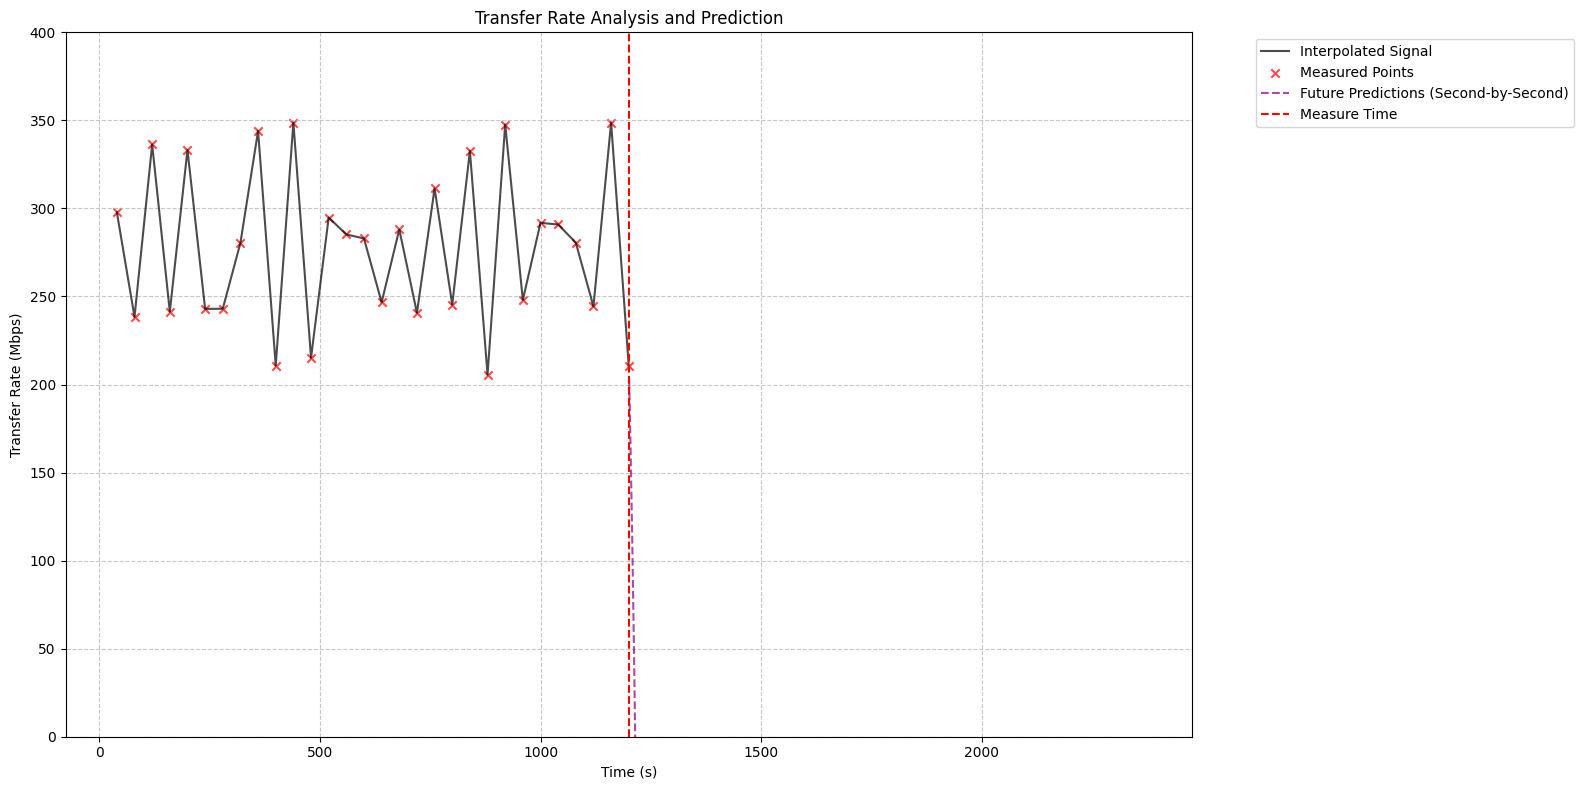

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d


def keep_dominant_frequencies(spectrum, keep_ratio):
    """
    Keeps the top `keep_ratio`% of dominant frequencies.
    """
    N = len(spectrum)
    num_to_keep = int(keep_ratio * N)  # Number of frequencies to retain

    # Get indices of top magnitudes
    dominant_indices = np.argsort(np.abs(spectrum))[-num_to_keep:]

    # Create a new spectrum with only the dominant frequencies
    filtered_spectrum = np.zeros_like(spectrum, dtype=complex)
    filtered_spectrum[dominant_indices] = spectrum[dominant_indices]

    return filtered_spectrum


# Read measured data
with open('log.txt', 'r') as f:
    lines = f.readlines()[1:]

time = []
rate = []
for line in lines:
    parts = line.strip().split(',')
    if len(parts) == 2:
        time.append(float(parts[0]))
        rate.append(float(parts[1]))

time = np.array(time)
rate = np.array(rate)

# Read time and rate from measured.txt
measured_time = []
measured_rate = []
with open('measured.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 2:
            measured_time.append(float(parts[0]))
            measured_rate.append(float(parts[1]))

measured_time = np.array(measured_time)
measured_rate = np.array(measured_rate)

# Combine log and measured data
combined_time = np.concatenate([time, measured_time])
combined_rate = np.concatenate([rate, measured_rate])

# Compute FFT
spectrum = fft(rate)
thresholds = {
    "25%": 0.75,
    "50%": 0.50,
    "75%": 0.25
}

reconstructed_rates = {}
for label, keep_ratio in thresholds.items():
    filtered_spectrum = keep_dominant_frequencies(spectrum, keep_ratio)
    reconstructed_rates[label] = ifft(filtered_spectrum).real

# Generate future time series (one second at a time)
future_start = combined_time.max() + 1
future_end = future_start + (combined_time.max() - combined_time.min())
future_time = np.arange(future_start, future_end + 1, 1)  # Second-by-second predictions

# Interpolation function for smooth prediction
interp_func = interp1d(time, reconstructed_rates['50%'], kind='cubic', fill_value='extrapolate')
future_rate = interp_func(future_time)

# Save to predictions.txt
with open('predictions.txt', 'w') as f:
    for t, r in zip(future_time, future_rate):
        f.write(f'{t},{r}\n')

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(combined_time, combined_rate, label='Interpolated Signal', alpha=0.7, color='black')
plt.scatter(combined_time, combined_rate, color='red', marker='x', label='Measured Points', alpha=0.7)
plt.plot(future_time, future_rate, '--', color='purple', label='Future Predictions (Second-by-Second)', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Transfer Rate (Mbps)')
plt.ylim(bottom=0, top=400)
plt.axvline(x=combined_time.max(), color='red', linestyle='--', label='Measure Time')

# Move legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Transfer Rate Analysis and Prediction')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('rate_prediction.png', bbox_inches='tight')
plt.show()

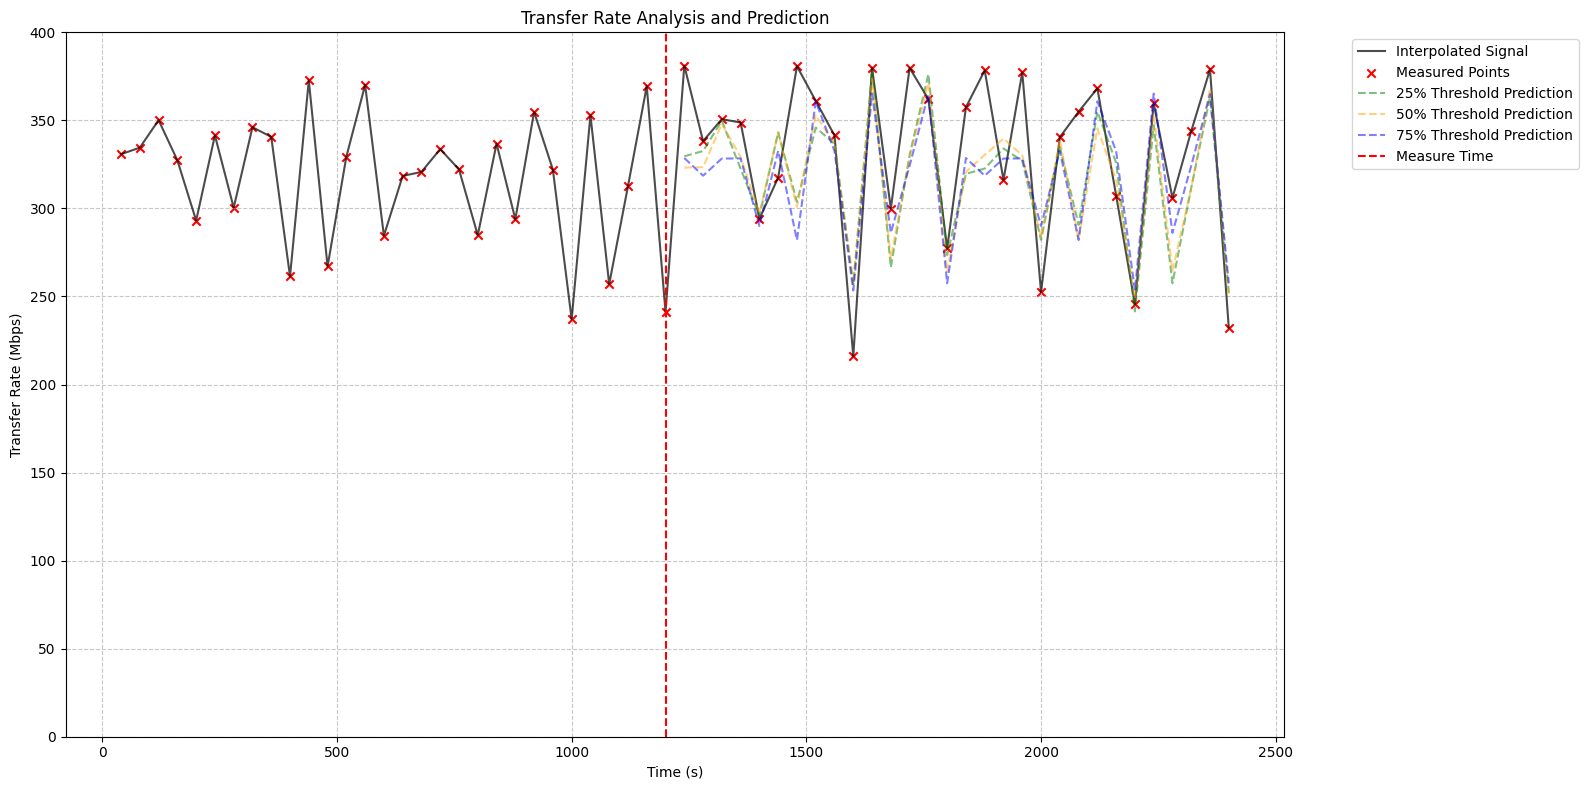

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft


def keep_dominant_frequencies(spectrum, keep_ratio):
    """
    Keeps the top `keep_ratio`% of dominant frequencies.
    """
    N = len(spectrum)
    num_to_keep = int(keep_ratio * N)  # Number of frequencies to retain

    # Get indices of top magnitudes
    dominant_indices = np.argsort(np.abs(spectrum))[-num_to_keep:]

    # Create a new spectrum with only the dominant frequencies
    filtered_spectrum = np.zeros_like(spectrum, dtype=complex)
    filtered_spectrum[dominant_indices] = spectrum[dominant_indices]

    return filtered_spectrum



with open('log.txt', 'r') as f:
    lines = f.readlines()[1:]

time = []
rate = []
for line in lines:
    parts = line.strip().split(',')
    if len(parts) == 2:
        time.append(float(parts[0]))
        rate.append(float(parts[1]))

time = np.array(time)
rate = np.array(rate)


# Read time and rate from measured.txt
measured_time = []
measured_rate = []
with open('measured.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 2:
            measured_time.append(float(parts[0]))
            measured_rate.append(float(parts[1]))

measured_time = np.array(measured_time)
measured_rate = np.array(measured_rate)

combined_time = np.concatenate([time, measured_time])
combined_rate = np.concatenate([rate, measured_rate])

# Interpolate only the missing points
full_time = np.arange(time.min(), time.max() + 1, 1)
known_indices = np.isin(full_time, time)


# Compute FFT
spectrum = fft(rate)
thresholds = {
    "25%": 0.75,
    "50%": 0.50,
    "75%": 0.25
}

reconstructed_rates = {}
for label, keep_ratio in thresholds.items():
    filtered_spectrum = keep_dominant_frequencies(spectrum, keep_ratio)
    reconstructed_rates[label] = ifft(filtered_spectrum).real

freqs = np.fft.fftfreq(len(rate), d=(full_time[1] - full_time[0]))

future_time = full_time[-1] + (full_time - full_time[0])

with open('predictions.txt', 'w') as f:
    for t, r in zip(future_time, reconstructed_rates['25%']):
        f.write(f'{t},{r}\n')

plt.figure(figsize=(16, 8))
plt.plot(combined_time, combined_rate, label='Interpolated Signal', alpha=0.7, color='black')
plt.scatter(combined_time, combined_rate, color='red', marker='x', label='Measured Points', alpha=1)
plt.plot(1200 + time, reconstructed_rates['25%'], '--', color='green', label='25% Threshold Prediction', alpha = 0.5)
plt.plot(1200 + time, reconstructed_rates['50%'], '--', color='orange', label='50% Threshold Prediction', alpha = 0.5)
plt.plot(1200 + time, reconstructed_rates['75%'], '--', color='blue', label='75% Threshold Prediction', alpha = 0.5)

plt.xlabel('Time (s)')
plt.ylabel('Transfer Rate (Mbps)')
plt.ylim(bottom=0, top=400)
plt.axvline(x=1200, color='red', linestyle='--', label='Measure Time')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Transfer Rate Analysis and Prediction')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('rate_prediction.png')
plt.show()

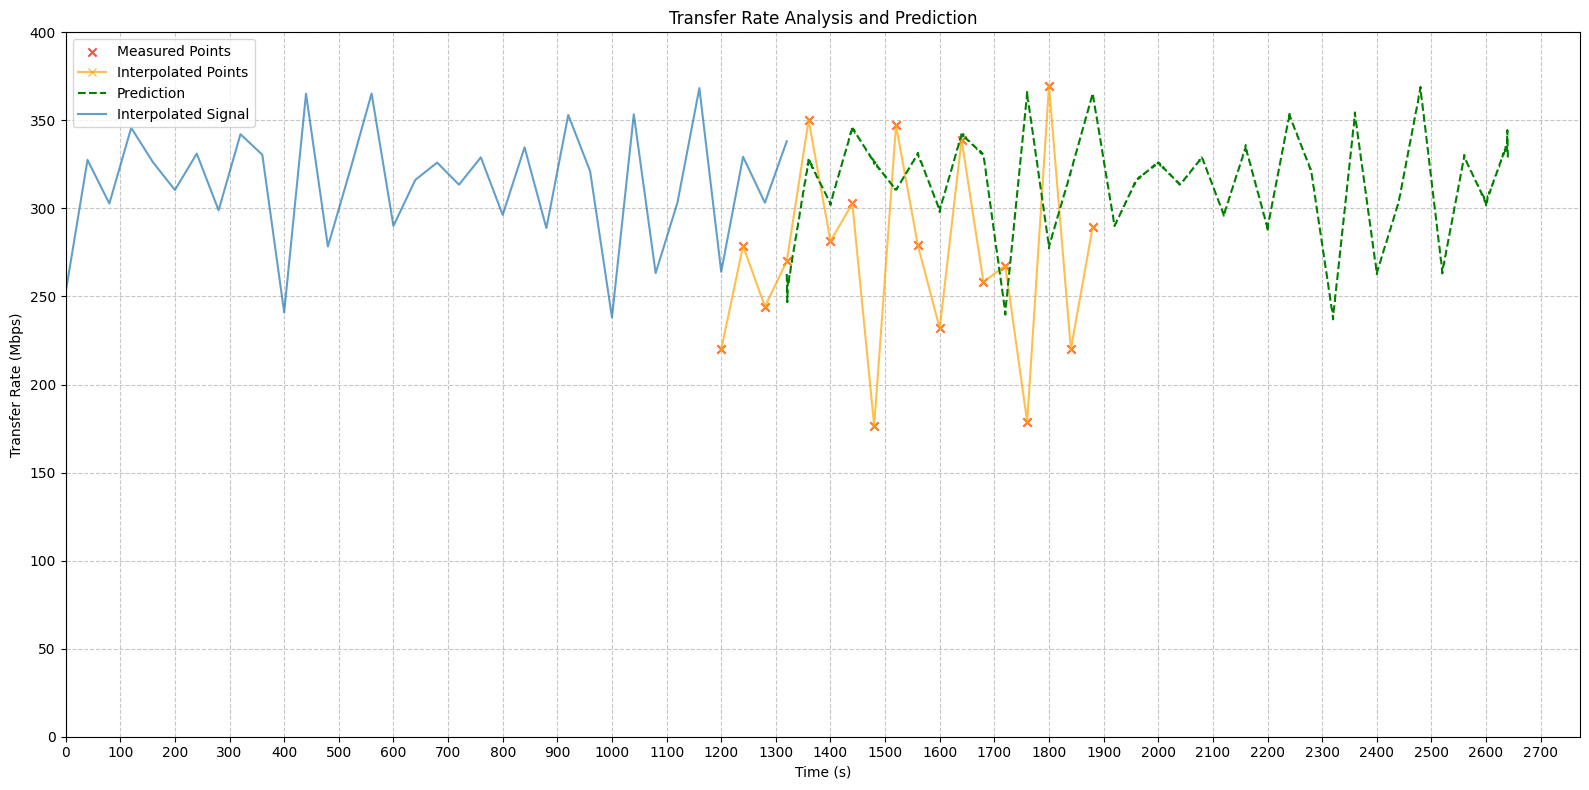

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# Read time and rate from log.txt
with open('log.txt', 'r') as f:
    lines = f.readlines()[1:]  # Skip the header

time = []
rate = []
for line in lines:
    parts = line.strip().split(',')
    if len(parts) == 2:
        time.append(float(parts[0]))
        rate.append(float(parts[1]))

time = np.array(time)
rate = np.array(rate)


# Read time and rate from measured.txt
measured_time = []
measured_rate = []
with open('measured.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 2:
            measured_time.append(float(parts[0]))
            measured_rate.append(float(parts[1]))

measured_time = np.array(measured_time)
measured_rate = np.array(measured_rate)

combined_time = np.concatenate([time, measured_time])
combined_rate = np.concatenate([rate, measured_rate])

# Interpolate only the missing points
full_time = np.arange(time.min(), time.max() + 1, 1)
known_indices = np.isin(full_time, time)
interpolated_rate = np.interp(full_time, time, rate)

# Mark known and interpolated points
rate_with_marks = np.where(known_indices, interpolated_rate, np.nan)

# Compute FFT
spectrum = fft(interpolated_rate)
freqs = np.fft.fftfreq(len(interpolated_rate), d=(full_time[1] - full_time[0]))

# Find the indices of the top N dominant frequencies
N = int(0.75 * len(spectrum))  # Keep 10% of the strongest frequencies
dominant_indices = np.argsort(np.abs(spectrum))[-N:]  # Get indices of top N magnitudes

# Create a new spectrum with only the dominant frequencies
filtered_spectrum = np.zeros_like(spectrum, dtype=complex)
filtered_spectrum[dominant_indices] = spectrum[dominant_indices]  # Retain only dominant frequencies

# Inverse FFT to reconstruct
reconstructed_rate = ifft(filtered_spectrum).real

# Extend time for future prediction
future_time = full_time[-1] + (full_time - full_time[0])

# Save predicted times and rates to prediction.txt
with open('predictions.txt', 'w') as f:
    for t, r in zip(future_time, reconstructed_rate):
        f.write(f'{t},{r}\n')

# Plot original and reconstructed signals
plt.figure(figsize=(16, 8))
plt.scatter(measured_time, measured_rate, color='red', marker='x', label='Measured Points', alpha=0.7)
plt.plot(measured_time, measured_rate, color='orange', marker='x', label='Interpolated Points', alpha=0.7)
plt.plot(future_time, reconstructed_rate, '--', color='green', label='Prediction')
plt.plot(time, rate, label='Interpolated Signal', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Transfer Rate (Mbps)')
plt.ylim(bottom=0, top=400)
plt.xlim(left=1200)
plt.xticks(np.arange(0, future_time.max() + 100, 100))
# plt.axvline(x=full_time[-1], color='black', linestyle='--', label='Measure Time')
plt.legend()
plt.title('Transfer Rate Analysis and Prediction')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('rate_prediction.png')
plt.show()